In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error
from collections import Counter
import textwrap
import bitsandbytes
import torch
from transformers import pipeline
from transformers.utils import logging

logging.set_verbosity_error()

In [50]:
articles_df = pd.read_csv('scopus_articles_data.csv')
articles_df.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...


In [51]:
abstracts = articles_df['Abstract'].dropna().tolist()

In [52]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

2025-07-05 18:17:41.821736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 3.4 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.9 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 4.0 MB/s eta 0:00:03
     ----------- ---------------------------- 3.7/12.8 MB 4.1 MB/s eta 0:00:03
     -------------- ------------------------- 4.7/12.8 MB 4.3 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 4.3 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.4 MB/s eta 0:00:02
     ------------------------ --------------- 7.9/12.8 MB 4.5 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 4.5 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 4.6 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 4.6 MB

In [53]:
def preprocess_texts(texts):
    def process_text(text):
        return ' '.join([
            token.lemma_.lower()
            for token in text
            if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
        ])

    return [process_text(text) for text in nlp.pipe(texts, batch_size=50, n_process=4)]

processed_abstracts = preprocess_texts(abstracts)
print(abstracts[0:5])
print(processed_abstracts[0:5])


['With artificial intelligence permeating conversations and marketing interactions through digital technologies and media, machine learning models, in particular, natural language processing (NLP) models, have surged in popularity for analyzing unstructured data in marketing. Yet, we do not fully understand which NLP models are appropriate for which marketing applications and what insights can be best derived from them. We review different NLP models and their applications in marketing. We layout the advantages and disadvantages of these models and highlight the conditions under which different models are appropriate in the marketing context. We introduce the latest neural autoencoder NLP models, demonstrate these models to analyze new product announcements and news articles, and provide an empirical comparison of the different autoencoder models along with the statistical NLP models. We discuss the insights from the comparison and offer guidelines for researchers. We outline future ex

In [54]:
def create_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 8)) 

    wrapped_labels = [ '\n'.join(textwrap.wrap(str(label), 15)) for label in data.index ]

    ax = data.plot(kind='bar', color='cornflowerblue', edgecolor='black')

    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    plt.xticks(ticks=range(len(data)), labels=wrapped_labels, rotation=90, ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_grouped_bar_chart(indices, group1, group2, title, xlabel, ylabel):
    width = 0.35
    x = np.arange(len(indices))

    fig, ax = plt.subplots(figsize=(14, 8))
    bars1 = ax.bar(x - width/2, group1, width, label='Group 1', color='cornflowerblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, group2, width, label='Group 2', color='lightcoral', edgecolor='black')

    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, rotation=90, ha='center', fontsize=10)
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        if isinstance(height, int) or height.is_integer():
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.annotate(label,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

def create_bins_chart(data, title, xlabel, ylabel, bins_number=30):
    plt.hist(data, bins=bins_number, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()
    
def create_wordcloud(scored_tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(scored_tokens)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

[('nlp', 15612), ('language', 6962), ('data', 4948), ('processing', 4437), ('natural', 4283), ('based', 3842), ('models', 3380), ('text', 3232), ('model', 3186), ('learning', 2969), ('research', 2790), ('analysis', 2782), ('paper', 2680), ('information', 2574), ('results', 2537), ('methods', 2224), ('study', 2190), ('system', 2114), ('tasks', 2081), ('techniques', 2031), ('use', 1797), ('approach', 1795), ('performance', 1735), ('machine', 1638), ('method', 1524), ('different', 1471), ('systems', 1458), ('clinical', 1455), ('accuracy', 1417), ('task', 1404), ('proposed', 1327), ('applications', 1321), ('word', 1310), ('work', 1294), ('classification', 1224), ('time', 1221), ('computational', 1194), ('knowledge', 1170), ('process', 1152), ('ieee', 1117), ('new', 1101), ('sentiment', 1095), ('tools', 1073), ('large', 1049), ('human', 1022), ('training', 1020), ('deep', 1006), ('association', 1004), ('semantic', 1000), ('problem', 997), ('domain', 992), ('extraction', 984), ('features', 9

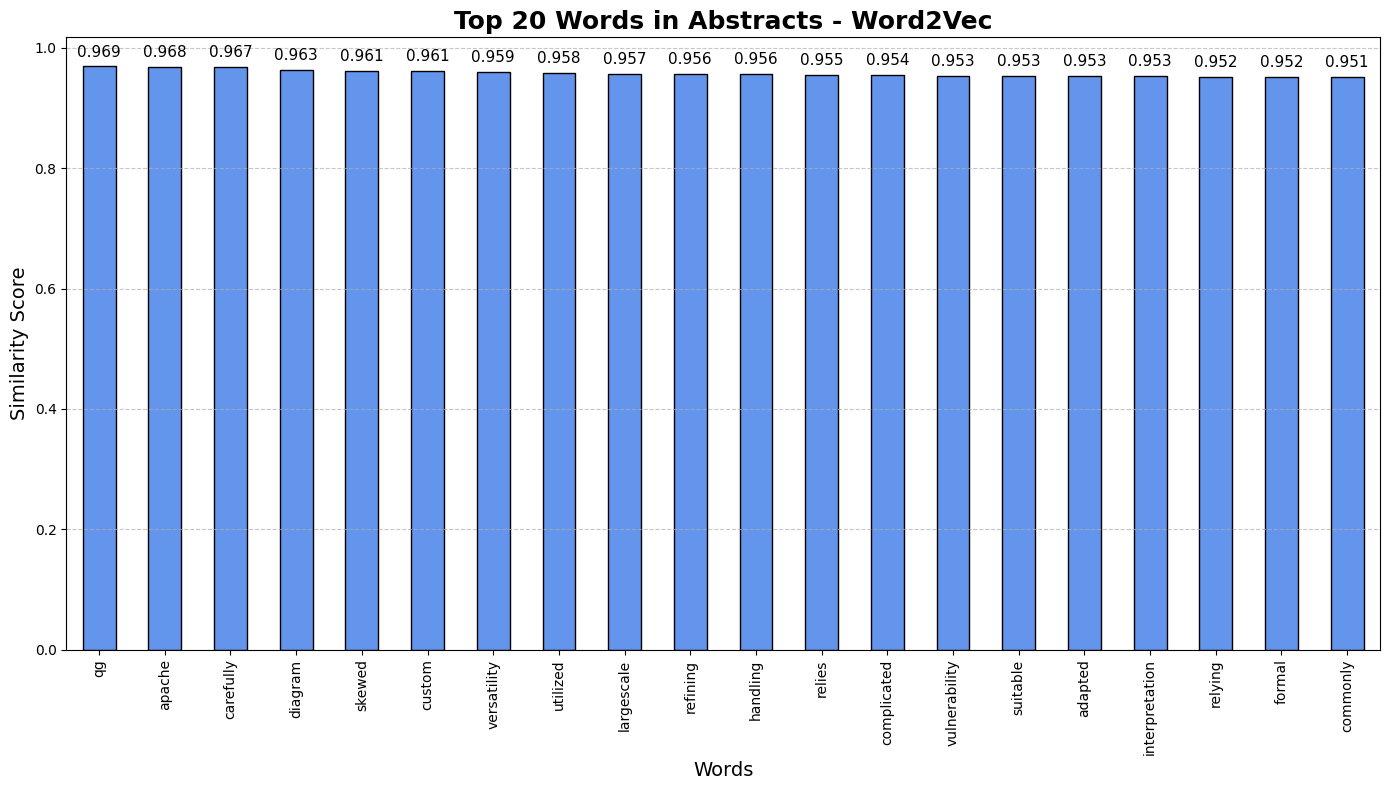

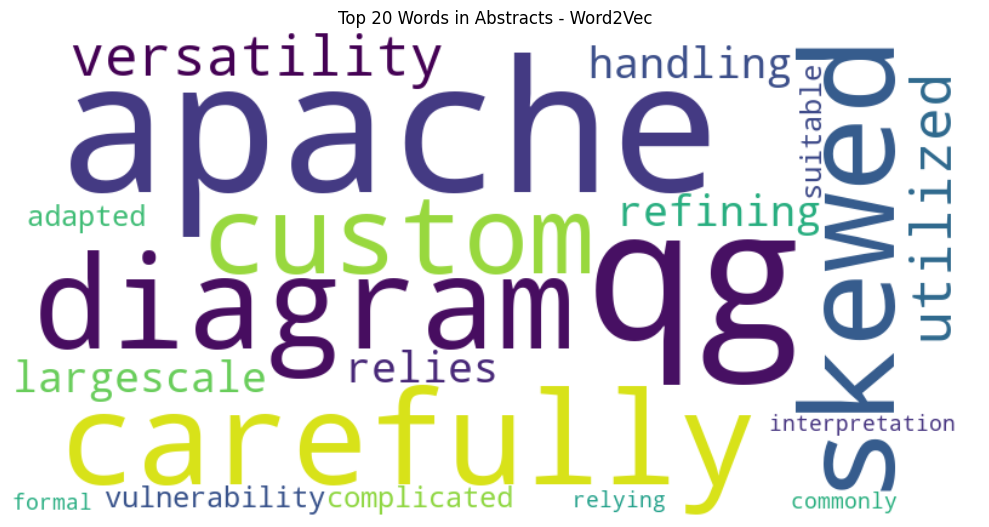

In [55]:
abstracts_splitted_tokens = [text.split() for text in processed_abstracts]
model = Word2Vec(sentences=abstracts_splitted_tokens, vector_size=300, window=7, min_count=3, workers=4)

all_tokens = [token for tokens in abstracts_splitted_tokens for token in tokens if token in model.wv]
mean_vector = sum(model.wv[token] for token in all_tokens) / len(all_tokens)
similar_words = model.wv.similar_by_vector(mean_vector, topn=20)
top_100_words = model.wv.index_to_key[:100]
top_100_words_with_counts = [(word, model.wv.get_vecattr(word, "count")) for word in top_100_words]
print(top_100_words_with_counts)
words, scores = zip(*similar_words)

create_bar_chart(pd.Series(scores, index=words), "Top 20 Words in Abstracts - Word2Vec", "Words", "Similarity Score")
create_wordcloud(dict(similar_words), "Top 20 Words in Abstracts - Word2Vec")


              word     score
14685          nlp  0.044641
12004     language  0.028848
5202          data  0.026594
13805       models  0.022099
21919         text  0.020515
13795        model  0.019902
12140     learning  0.019899
1998         based  0.019892
17177   processing  0.019744
14357      natural  0.019278
938       analysis  0.017820
18600     research  0.017767
10783  information  0.017307
15757        paper  0.016593
21694        tasks  0.016204
21561       system  0.015338
21767   techniques  0.014554
13430      methods  0.014241
18722      results  0.013881
21021        study  0.013112


<Figure size 1400x800 with 0 Axes>

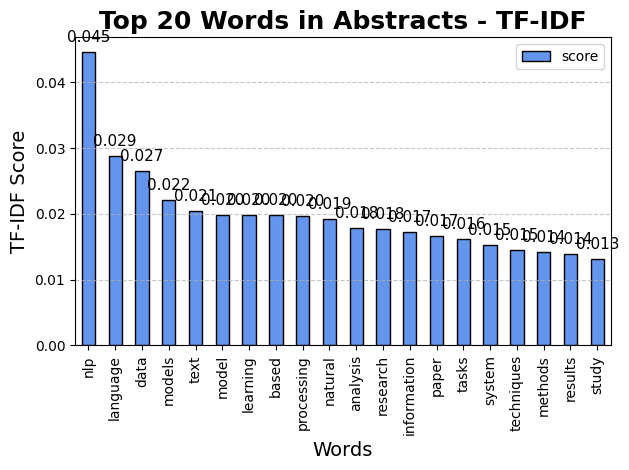

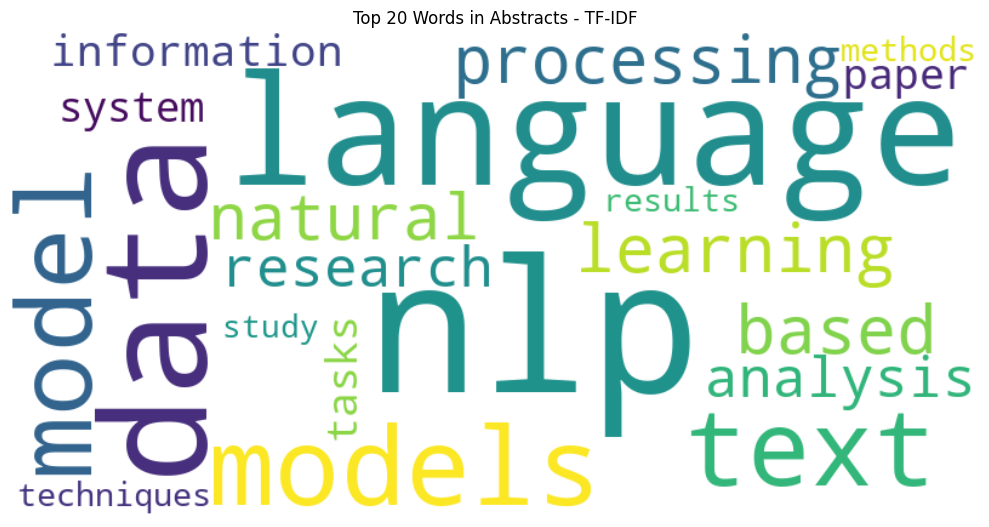

In [56]:

def extract_top_tfidf_words(texts, top_n=20):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.mean(axis=0).A1 
    words = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return tfidf_df

top_words_df = extract_top_tfidf_words(processed_abstracts)
print(top_words_df)

create_bar_chart(top_words_df.set_index('word'), "Top 20 Words in Abstracts - TF-IDF", "Words", "TF-IDF Score")
create_wordcloud(dict(zip(top_words_df['word'], top_words_df['score'])), "Top 20 Words in Abstracts - TF-IDF")


378/378 [==============================] - 0s 521us/step
Top 20 words with highest reconstruction error:
state: 0.007520
world: 0.007363
artificial: 0.006151
intelligence: 0.005077
neural: 0.005076
information: 0.004042
linguistics: 0.003947
decision: 0.003715
art: 0.003666
data: 0.003297
large: 0.003158
association: 0.002963
results: 0.002955
learning: 0.002887
computational: 0.002688
networks: 0.002630
knowledge: 0.002604
text: 0.002574
et: 0.002555
word: 0.002550


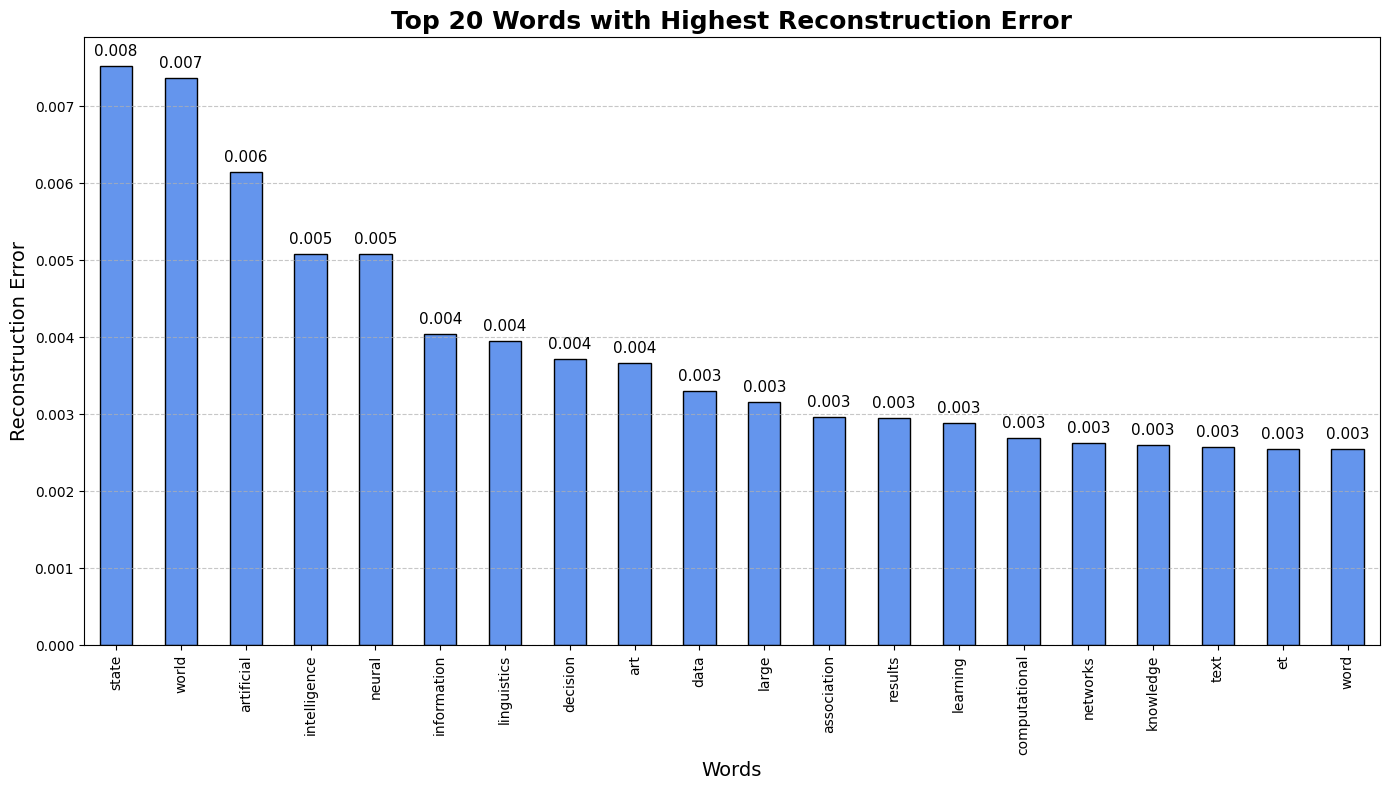

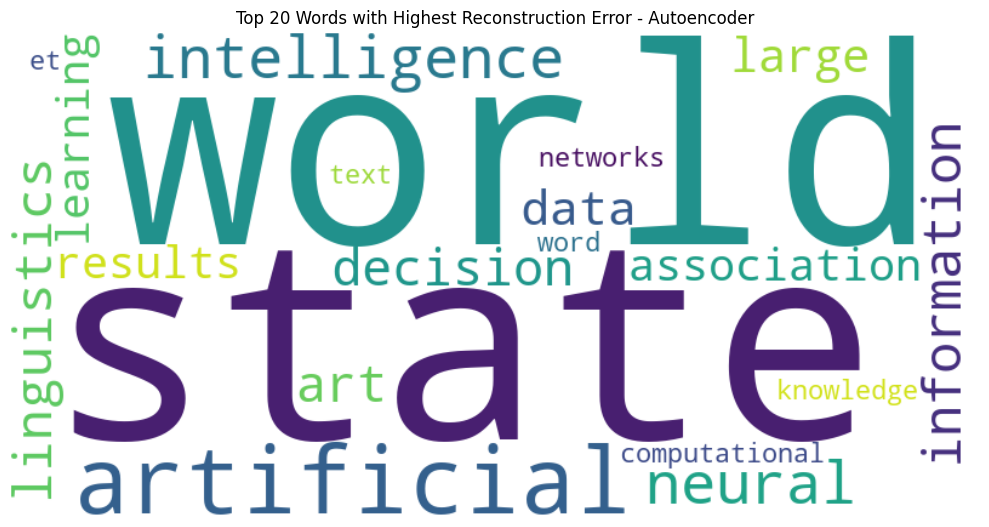

In [57]:

words = model.wv.index_to_key
vectors = np.array([model.wv[word] for word in words])
input_dim = vectors.shape[1]

# the autoencoder gets the Word2Vec vectors as input
input_layer = Input(shape=(input_dim,))
# the encoder compresses the input vectors to a lower dimension
encoded = Dense(128, activation='relu')(input_layer)
# the decoder reconstructs the original vectors from the compressed representation
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(vectors, vectors, epochs=50, batch_size=256, shuffle=True, verbose=0)


predicted_vectors = autoencoder.predict(vectors)
errors = [mean_squared_error(vectors[i], predicted_vectors[i]) for i in range(len(vectors))]
word_errors = list(zip(words, errors))

word_errors_sorted = sorted(word_errors, key=lambda x: x[1], reverse=True)

print(f"Top {20} words with highest reconstruction error:")
for word, error in word_errors_sorted[:20]:
    print(f"{word}: {error:.6f}")
create_bar_chart(pd.Series([error for _, error in word_errors_sorted[:20]], index=[word for word, _ in word_errors_sorted[:20]]),
                  "Top 20 Words with Highest Reconstruction Error", "Words", "Reconstruction Error")
create_wordcloud(dict(word_errors_sorted[:20]), "Top 20 Words with Highest Reconstruction Error - Autoencoder")

# NER

In [58]:
nlp.enable_pipe("ner")
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=4):
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities
entities = extract_entities(abstracts)

In [59]:
entity_counter = Counter(entities)
print("Top 20 entities seen with their types:")
for (ent, label), count in entity_counter.most_common(20):
    print(f"{ent} ({label}): {count}")

Top 20 entities seen with their types:
NLP (ORG): 14499
two (CARDINAL): 1047
first (ORDINAL): 637
three (CARDINAL): 620
Natural Language Processing (ORG): 604
AI (ORG): 489
English (LANGUAGE): 464
2015 (DATE): 451
2019 (DATE): 418
BERT (ORG): 416
2017 (DATE): 397
2018 (DATE): 376
2025 (DATE): 371
2021 (DATE): 362
2022 (DATE): 348
2 (CARDINAL): 336
one (CARDINAL): 331
2020 (DATE): 324
ML (ORG): 305
1 (CARDINAL): 303


# EDA

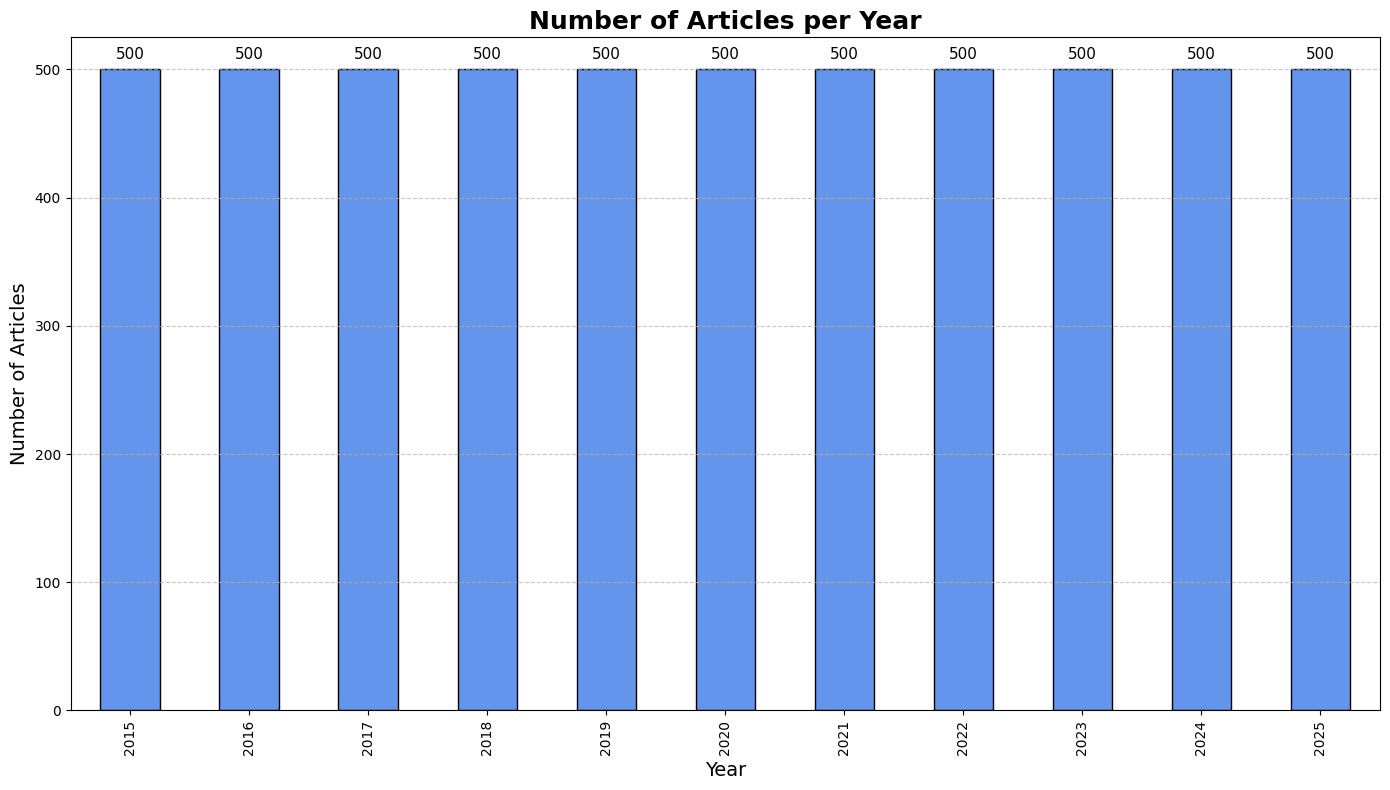

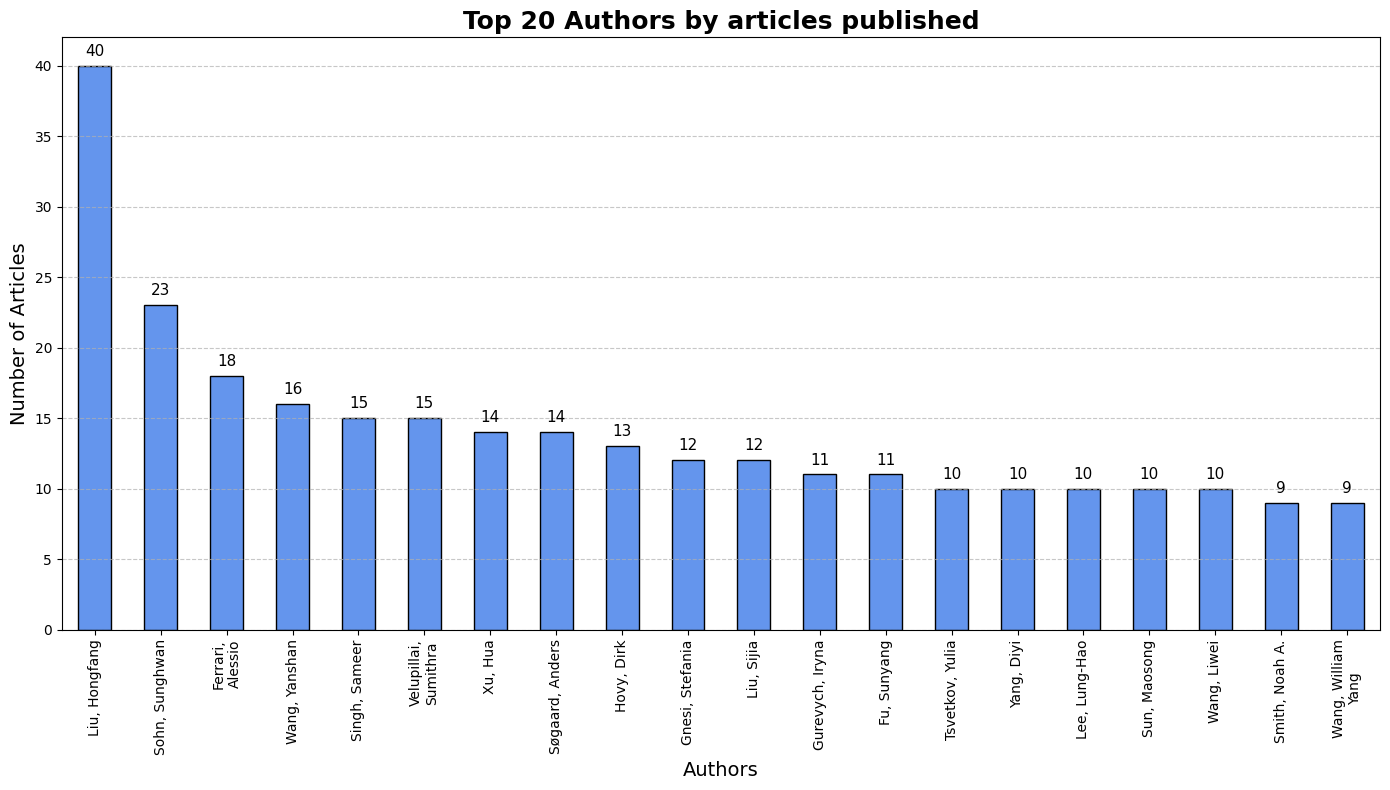

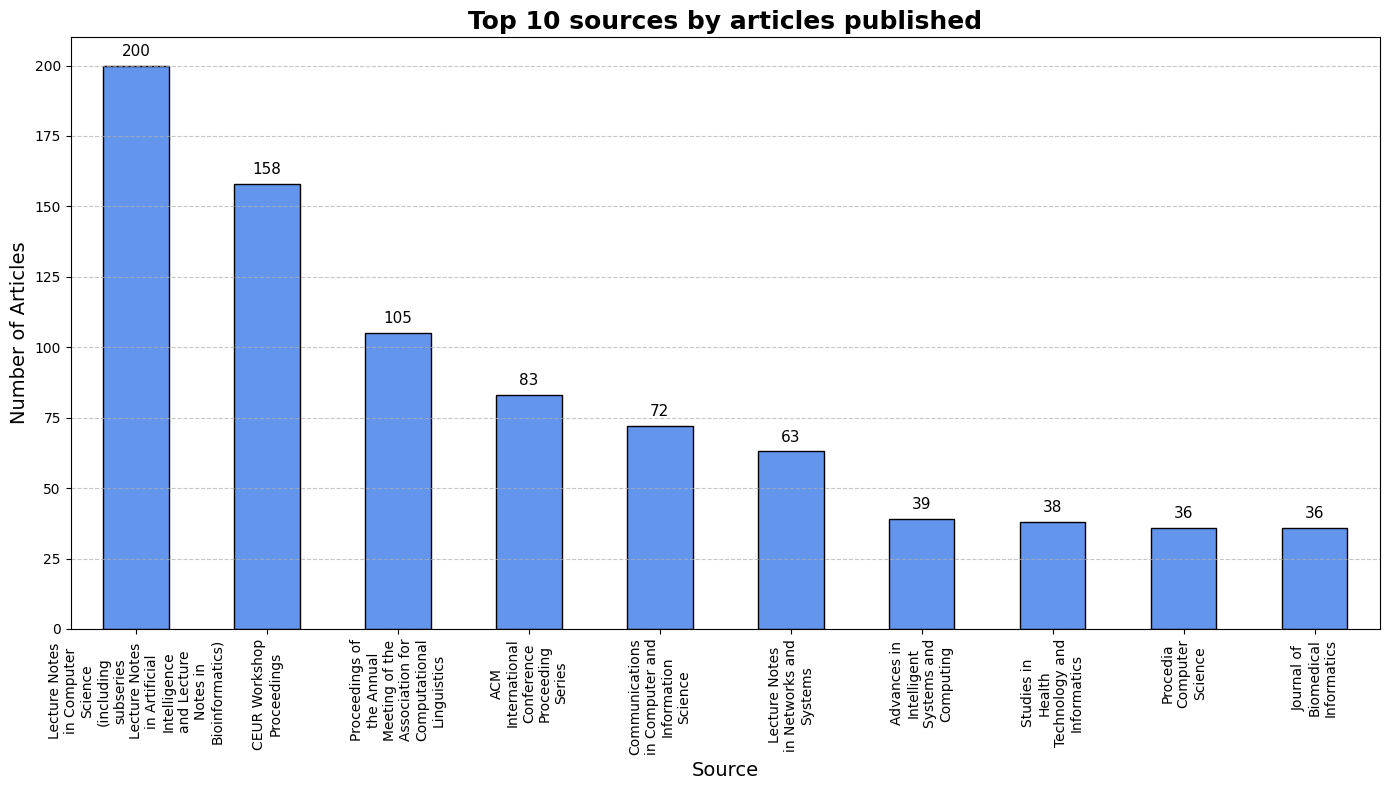

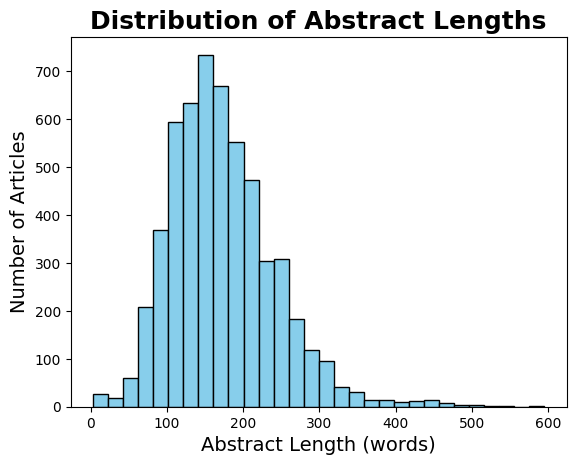

In [60]:
articles_per_year = articles_df['Year'].value_counts().sort_index()
create_bar_chart(articles_per_year, "Number of Articles per Year", "Year", "Number of Articles")
all_authors = articles_df['Author full names'].dropna().str.split(';').explode().str.strip()
all_authors = all_authors.str.replace(r'\s*\(.*?\)', '', regex=True)
top_authors = all_authors.value_counts().head(20)
create_bar_chart(top_authors, "Top 20 Authors by articles published", "Authors", "Number of Articles")

top_sources = articles_df['Source title'].value_counts().head(10)
create_bar_chart(top_sources, "Top 10 sources by articles published", "Source", "Number of Articles")

abstracts_lengths = articles_df['Abstract'].dropna().apply(lambda x: len(x.split()))
create_bins_chart(abstracts_lengths, "Distribution of Abstract Lengths", "Abstract Length (words)", "Number of Articles")

In [61]:
def combine_keywords(df):
    author_kws = df['Author Keywords'].fillna('').str.split(';')
    index_kws = df['Index Keywords'].fillna('').str.split(';')

    stop_keywords = {'man', 'woman', 'male', 'female', 'young adult', 'human', 'study', 'method', 'algorithms', 'article', 'adult', 'simple++', 'humans', "'current"}
    combined_keywords = []

    for a_kws, i_kws in zip(author_kws, index_kws):
        kws = set()
        if a_kws:
            kws.update([kw.strip().lower() for kw in a_kws if kw])
        if i_kws:
            kws.update([kw.strip().lower() for kw in i_kws if kw])
        kws = {kw for kw in kws if kw not in stop_keywords}
        combined_keywords.append(list(kws))

    return combined_keywords

In [62]:
articles_df['Combined Keywords'] = combine_keywords(articles_df)
articles_df.head(10)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Link,Abstract,Author Keywords,Index Keywords,Combined Keywords
0,Shankar V.; Parsana S.,"Shankar, Venkatesh (7102439832); Parsana, Sohi...",7102439832; 57200450074,An overview and empirical comparison of natura...,2022,Journal of the Academy of Marketing Science,https://www.scopus.com/inward/record.uri?eid=2...,With artificial intelligence permeating conver...,Artificial intelligence; Autoencoder; Machine ...,NaN,"[natural language processing (nlp), artificial..."
1,Chen K.; Meng Y.; Sun X.; Guo S.; Zhang T.; Li...,"Chen, Kangjie (57219735841); Meng, Yuxian (572...",57219735841; 57216617236; 57216611212; 5683490...,BADPRE: TASK-AGNOSTIC BACKDOOR ATTACKS TO PRE-...,2022,ICLR 2022 - 10th International Conference on L...,https://www.scopus.com/inward/record.uri?eid=2...,Pre-trained Natural Language Processing (NLP) ...,NaN,Backdoors; Down-stream; Foundation models; Key...,"[processing model, backdoors, key feature, dow..."
2,Hemavathi U.; Medona A.C.V.,"Hemavathi, U. (57226555469); Medona, Ann C. V....",57226555469; 57226547686,AI-Based Interactive Agent for Health Care Usi...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Artificial intelligence (AI)-based interactive...,Artificial intelligence; Deep learning; Health...,NaN,"[health care, artificial intelligence, natural..."
3,Bauer D.; Longley T.; Ma Y.; Wilson T.,"Bauer, Daniel (57197925699); Longley, Tom (574...",57197925699; 57425276200; 57286065200; 5805552...,NLP in Human Rights Research: Extracting Knowl...,2022,Proceedings of the 16th Linguistic Annotation ...,https://www.scopus.com/inward/record.uri?eid=2...,In this paper we explore the use of an NLP sys...,Applications; Ethics and Legal Issues; Informa...,Data mining; Knowledge graph; Law enforcement;...,"[applications, data mining, social aspects, et..."
4,Gessler L.,"Gessler, Luke (57219184334)",57219184334,Closing the NLP Gap: Documentary Linguistics a...,2022,COMPUTEL 2022 - 5th Workshop on the Use of Com...,https://www.scopus.com/inward/record.uri?eid=2...,"For decades, researchers in natural language p...",NaN,Application programs; Computational linguistic...,"[computational linguistics, model and algorith..."
5,Zhao X.; Li L.; Wang Y.-X.,"Zhao, Xuandong (57552407600); Li, Lei (5609407...",57552407600; 56094074700; 58912060300,Distillation-Resistant Watermarking for Model ...,2022,Findings of the Association for Computational ...,https://www.scopus.com/inward/record.uri?eid=2...,How can we protect the intellectual property o...,NaN,Classification (of information); Computational...,"[computational linguistics, text processing, p..."
6,Latha B.; Nivedha B.; Ranjanaa Y.,"Latha, B. (26643194000); Nivedha, B. (57202678...",26643194000; 57202678926; 58127747300,Visual Audio Summarization Based on NLP Models,2022,2022 1st International Conference on Computati...,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) uses compute...,Abstractive; comparison; extractive; Natural L...,Visual languages; Abstractive; Audio summariza...,"[processing model, natural language processing..."
7,Rajan A.; Salgaonkar A.,"Rajan, Annie (57215688946); Salgaonkar, Ambuja...",57215688946; 35485507600,Survey of NLP Resources in Low-Resource Langua...,2022,Lecture Notes in Networks and Systems,https://www.scopus.com/inward/record.uri?eid=2...,Research results in different subdomains of NL...,Konkani language; Natural language processing;...,NaN,"[sindhi language, nepali language, natural lan..."
8,Desai N.P.; Dabhi V.K.,"Desai, Nikita P. (26639236000); Dabhi, Vipul K...",26639236000; 24823939300,Resources and components for gujarati NLP syst...,2022,Artificial Intelligence Review,https://www.scopus.com/inward/record.uri?eid=2...,Natural Language Processing (NLP) represents t...,Components; Corpus; Gujarati; Indian language;...,Digital storage; Fake detection; Surveys; Auto...,"[indian language, gujarati,

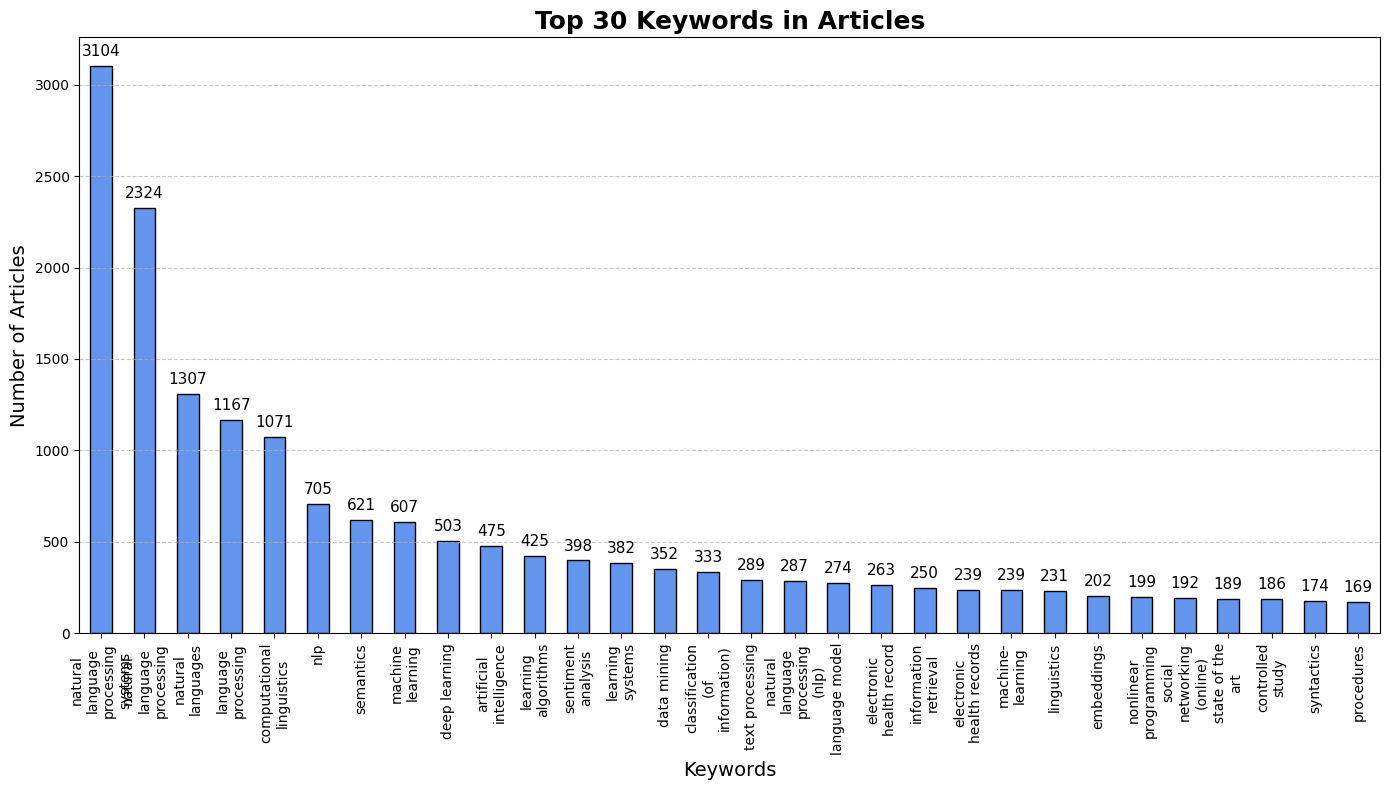

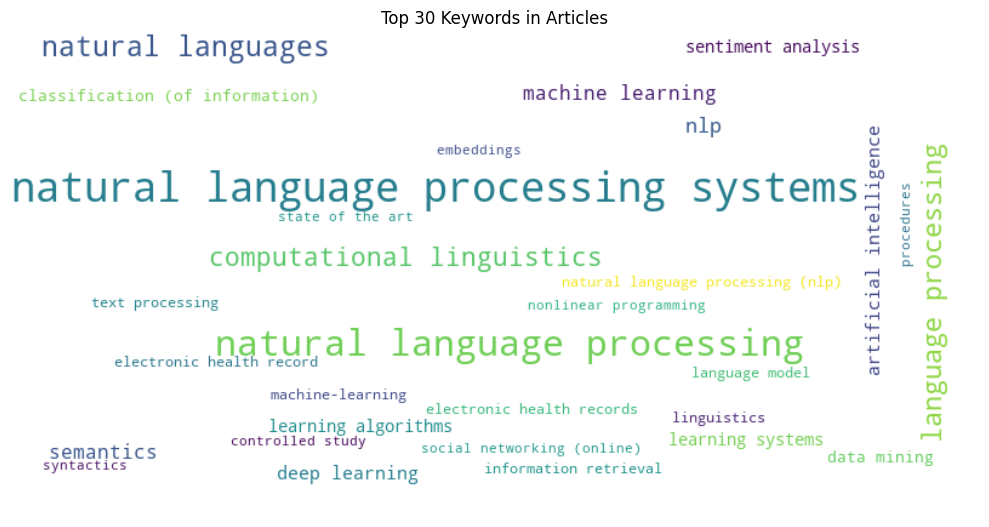

In [63]:
all_keywords = articles_df['Combined Keywords'].explode().dropna()
keyword_counts = all_keywords.value_counts().head(30)
create_bar_chart(keyword_counts, "Top 30 Keywords in Articles", "Keywords", "Number of Articles")
create_wordcloud(dict(keyword_counts), "Top 30 Keywords in Articles")

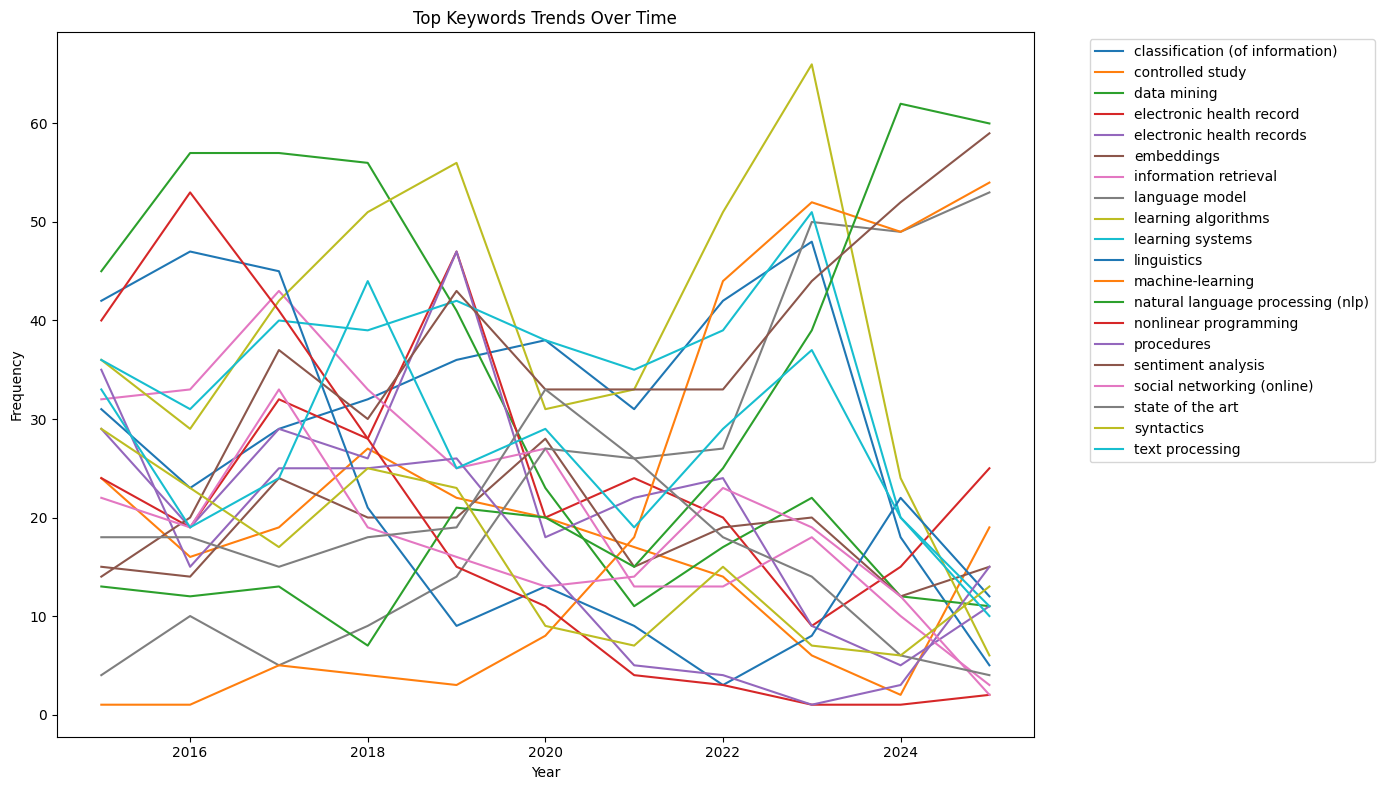

In [64]:
top_keywords = keyword_counts.index.tolist()[10:30]

articles_df['Combined Keywords'] = articles_df['Combined Keywords'].apply(lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else [])
keywords_year_df = articles_df.explode('Combined Keywords')

keywords_year_df = keywords_year_df[keywords_year_df['Combined Keywords'].isin(top_keywords)]

trend_data = (
    keywords_year_df.groupby(['Year', 'Combined Keywords'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14, 8))
for keyword in trend_data.columns:
    plt.plot(trend_data.index, trend_data[keyword], label=keyword)

plt.title("Top Keywords Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
exploded_keywords_df = articles_df[['Combined Keywords']].explode('Combined Keywords')
exploded_keywords_df['Combined Keywords'] = exploded_keywords_df['Combined Keywords'].str.lower().str.strip()

binary_matrix = pd.crosstab(exploded_keywords_df.index, exploded_keywords_df['Combined Keywords'])
top_keywords = exploded_keywords_df['Combined Keywords'].value_counts().head(1000).index
filtered_matrix = binary_matrix[top_keywords]
correlation_matrix = filtered_matrix.corr(method='pearson')
# correlation_matrix = binary_matrix.corr(method='pearson')
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)


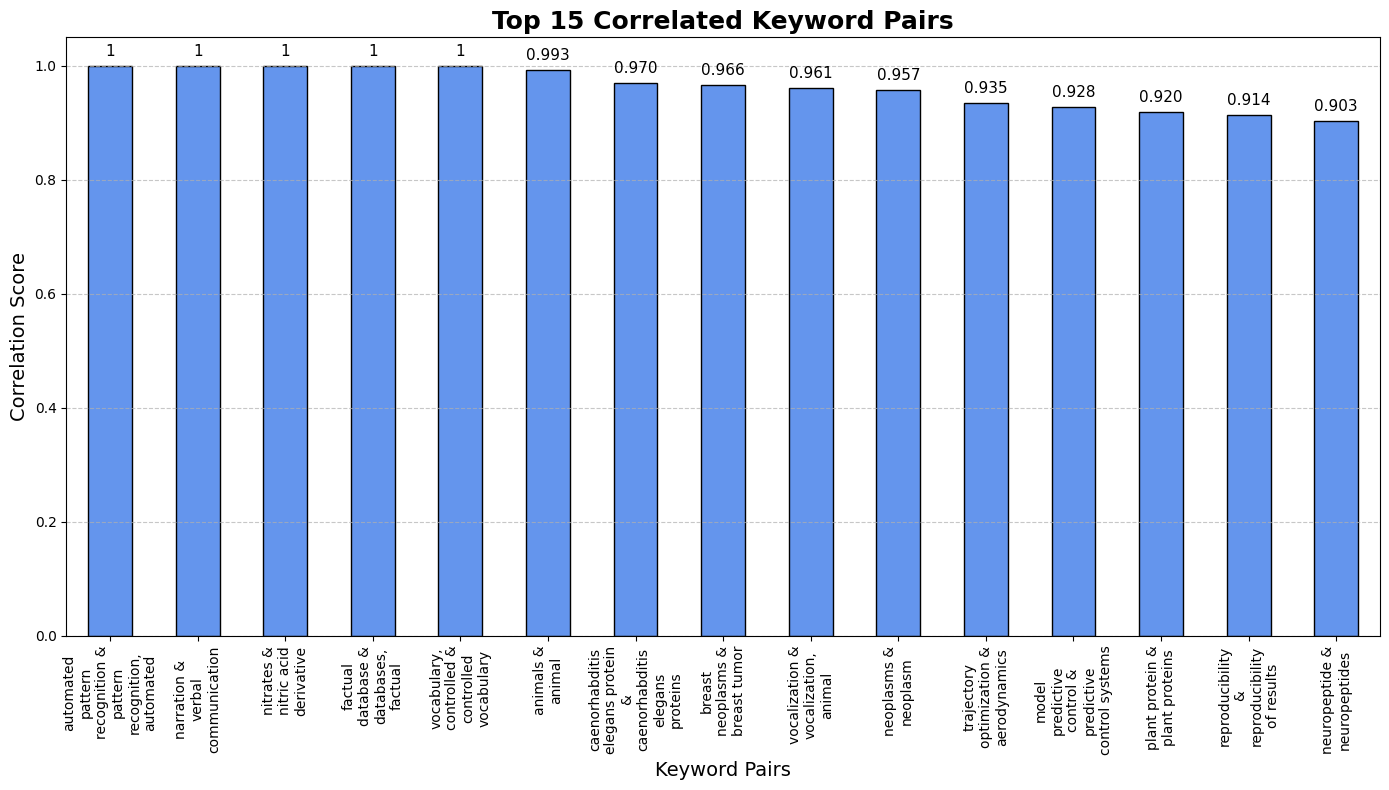

In [66]:
top_correlated_pairs = upper_triangle.stack().sort_values(ascending=False)

top_corr_pairs = top_correlated_pairs.head(15)

pair_labels = [f"{a} & {b}" for a, b in top_corr_pairs.index]
correlation_scores = top_corr_pairs.values

create_bar_chart(pd.Series(correlation_scores, index=pair_labels),
                  "Top 15 Correlated Keyword Pairs",
                    "Keyword Pairs", "Correlation Score")

In [67]:
keyword_year_df = articles_df[['Year', 'Combined Keywords']].explode('Combined Keywords')
keyword_year_df = keyword_year_df.dropna()

keyword_counts = keyword_year_df.groupby(['Combined Keywords', 'Year']).size().unstack(fill_value=0)

min_total_count = 30
total_counts = keyword_counts.sum(axis=1)
keyword_counts = keyword_counts[total_counts >= min_total_count]

z_scores = (keyword_counts - keyword_counts.mean(axis=1).values[:, None]) / keyword_counts.std(axis=1).values[:, None]
z_scores = z_scores.fillna(0)

top_z_keywords_per_year = {}
min_year_count = 10

for year in z_scores.columns:
    valid_keywords = keyword_counts[year] >= min_year_count
    filtered_z = z_scores[year][valid_keywords]
    top_keywords = filtered_z.sort_values(ascending=False).head(5)
    top_z_keywords_per_year[year] = top_keywords

keyword_only_dict = {
    year: list(keywords.index) for year, keywords in top_z_keywords_per_year.items()
}

trend_df_keywords = pd.DataFrame.from_dict(keyword_only_dict, orient='index')
trend_df_keywords.columns = [f"Place {i+1}" for i in range(trend_df_keywords.shape[1])]

display(trend_df_keywords)

,Place 1,Place 2,Place 3,Place 4,Place 5
2015,information science,electronic medical record,follow up,genetics,classification
2016,ontology,optimal control systems,optimization,semantic web,nonlinear programming
2017,education,software engineering,intelligent systems,social networking (online),requirements engineering
2018,recurrent neural networks,supervised learning,text processing,speech recognition,health care
2019,diagnostic imaging,gold standard,electronic health record,algorithm,electronic health records
2020,question answering,human experiment,embeddings,state of the art,named entity recognition
2021,large-scales,transfer learning,surveys,deep neural networks,covid-19
2022,parts-of-speech tagging,text data,support vector machines,forecasting,text classification
2023,e-learning,human language,case-studies,digital storage,transformers
2024,machine translation,adversarial machine learning,text analysis,language processing techniques,economic and social effects


In [68]:
top_keywords_per_year = (
    keyword_year_df
    .groupby(['Year', 'Combined Keywords'])
    .size()
    .reset_index(name='count')
    .sort_values(['Year', 'count'], ascending=[True, False])
)

print("\nMost frequent keywords per year:")
for year in sorted(keyword_year_df['Year'].unique()):
    year_keywords = top_keywords_per_year[top_keywords_per_year['Year'] == year].head(15)
    print(f"\n{year}:")
    for _, row in year_keywords.iterrows():
        print(f"{row['Combined Keywords']}: {row['count']}")


Most frequent keywords per year:

2015:
natural language processing systems: 268
natural language processing: 175
computational linguistics: 166
semantics: 84
artificial intelligence: 57
data mining: 45
linguistics: 42
nonlinear programming: 40
learning algorithms: 36
learning systems: 36
procedures: 35
text processing: 33
information retrieval: 32
priority journal: 32
classification (of information): 31

2016:
natural language processing systems: 262
natural language processing: 159
computational linguistics: 133
semantics: 75
data mining: 57
nonlinear programming: 53
artificial intelligence: 52
linguistics: 47
nlp: 39
information retrieval: 33
learning systems: 31
learning algorithms: 29
natural languages: 24
ontology: 24
classification (of information): 23

2017:
natural language processing systems: 289
natural language processing: 165
semantics: 75
computational linguistics: 69
data mining: 57
nlp: 57
artificial intelligence: 49
natural languages: 47
linguistics: 45
information re

In [69]:
summarizer = pipeline("summarization", model="t5-small")
def summarize_text(text):
    try:
        summary = summarizer("summarize: " + text, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""
SUM_N = 30
summarized_abstracts = [summarize_text(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]


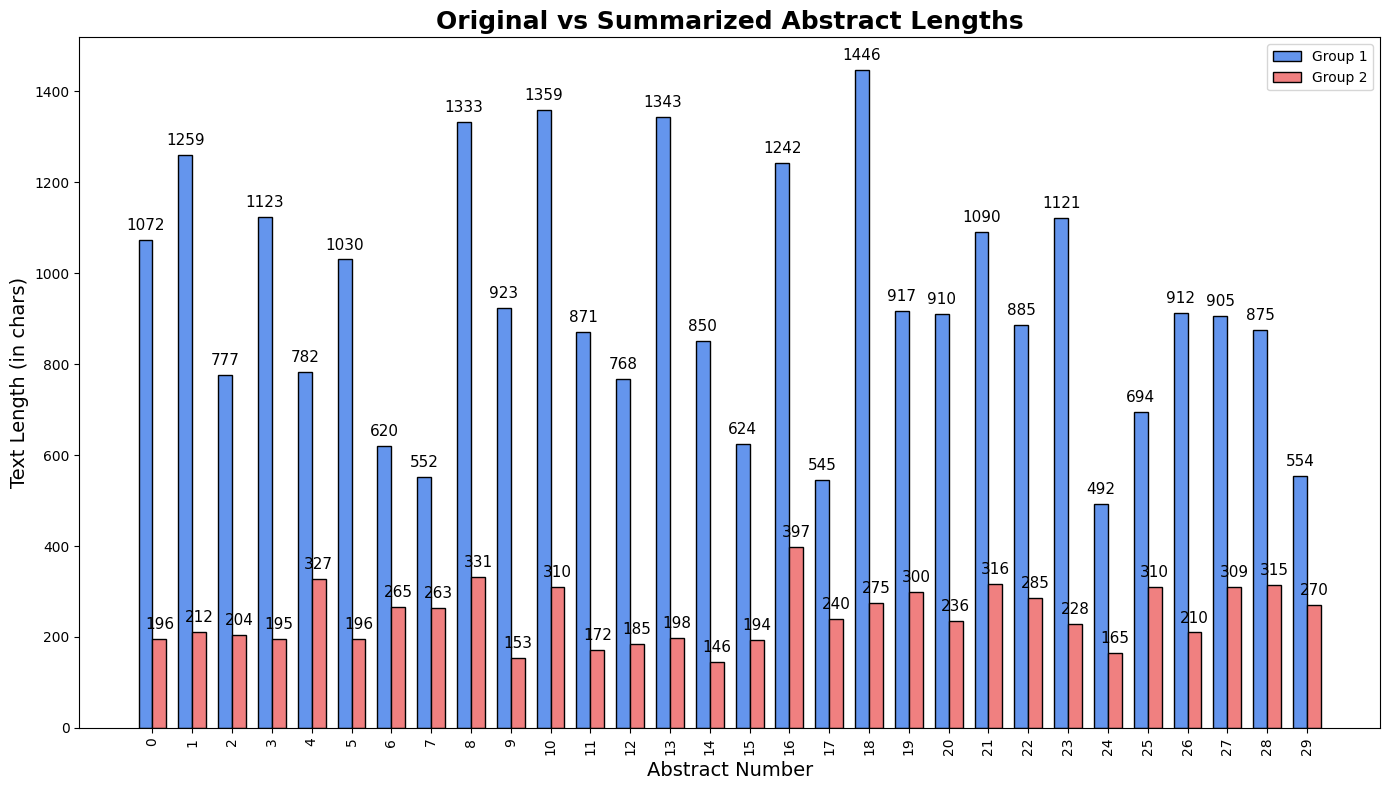

In [70]:
original_lengths = [len(abstract) for abstract in abstracts[:SUM_N] if isinstance(abstract, str)]
summary_lengths = [len(summary) for summary in summarized_abstracts]

indices = range(len(original_lengths))

create_grouped_bar_chart(indices, original_lengths, summary_lengths,
                          "Original vs Summarized Abstract Lengths",
                            "Abstract Number", "Text Length (in chars)")